In [1]:
from Chemometrics.import_common import *
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = 'SimHei'
%matplotlib inline

In [2]:
with open('数据汇总.csv') as csv:
    df = pd.read_csv(csv,delimiter='\t')

In [3]:
hplc = df.dropna(axis=1)

In [4]:
from sklearn.preprocessing import LabelEncoder
X = hplc.loc['1':,'1':]
y = hplc['分类编号'][1:]
y = LabelEncoder().fit_transform(y)

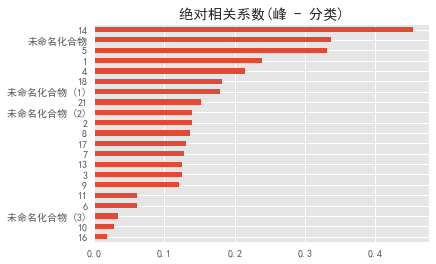

In [5]:
#相关系数
corr = np.corrcoef(np.vstack([X.T.values,y.reshape(1,-1)]))[-1,:-1]
s_corr = pd.Series(abs(corr),index=X.columns)
s_corr.sort_values().plot.barh()
plt.title('绝对相关系数(峰 - 分类)')

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif,mutual_info_classif

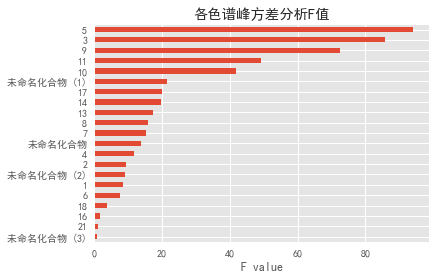

In [7]:
#方差分析F值
a = SelectKBest(f_classif,k='all').fit(X,y)
s_F = pd.Series(abs(a.scores_),index=X.columns)
s_F.sort_values().plot.barh()
plt.title('各色谱峰方差分析F值')
plt.xlabel('F value')

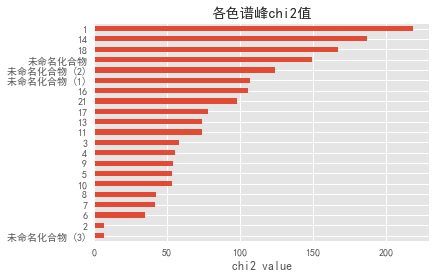

In [8]:
#chi2
a = SelectKBest(chi2,k='all').fit(X,y)
s_chi2 = pd.Series(abs(a.scores_),index=X.columns)
s_chi2.sort_values().plot.barh()
plt.title('各色谱峰chi2值')
plt.xlabel('chi2 value')

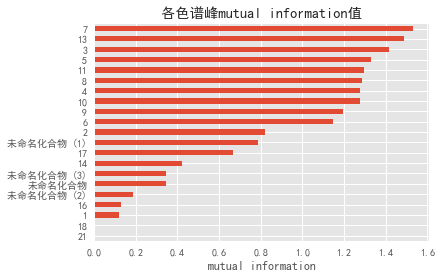

In [9]:
#mutual information互信息
a = SelectKBest(mutual_info_classif,k='all').fit(X,y)
s_mi = pd.Series(abs(a.scores_),index=X.columns)
s_mi.sort_values().plot.barh()
plt.title('各色谱峰mutual information值')
plt.xlabel('mutual information')

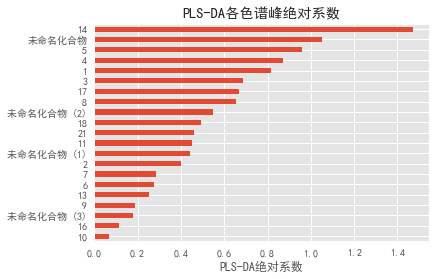

In [10]:
#PLS-DA coef
from sklearn.cross_decomposition import PLSRegression
plsr = PLSRegression()
clf = plsr.fit(X,y)
s_plsda_coef = pd.Series(abs(plsr.coef_.flatten()),index=X.columns)
s_plsda_coef.sort_values().plot.barh()
plt.title('PLS-DA各色谱峰绝对系数')
plt.xlabel('PLS-DA绝对系数')

In [11]:
def VIP(plsr,X):
    """
    The VIP score of a variable is calculated as a weighted sum of the squared correlations between the PLS-DA components and the original variable. The weights correspond to the percentage variation explained by the PLS-DA component in the model. 
    """
    w = make_weights(np.var(plsr.x_scores_,axis=0))
    n = plsr.n_components
    scorr = np.corrcoef(np.vstack([X.T,plsr.x_scores_.T]))[:-n,-n:]**2
    VIP = scorr.dot(w).flatten()
    return VIP

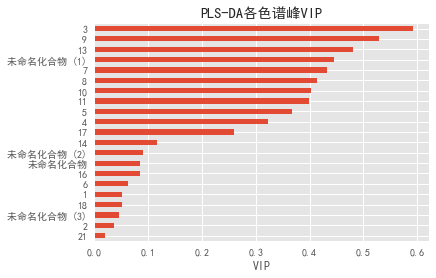

In [12]:
#PLS-DA VIP
s_VIP = pd.Series(VIP(plsr,X),index=X.columns)
s_VIP.sort_values().plot.barh()
plt.title('PLS-DA各色谱峰VIP')
plt.xlabel('VIP')

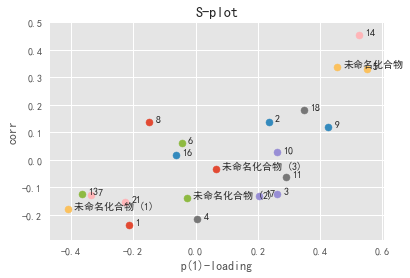

In [13]:
#S-plot
for i in range(len(X.columns)):
    plt.scatter(plsr.x_loadings_[i,0],corr[i],label=X.columns[i])
    plt.text(plsr.x_loadings_[i,0]+.02,corr[i],X.columns[i])
plt.title('S-plot')
plt.xlabel('p(1)-loading')
plt.ylabel('corr')
s_P1 = pd.Series(np.abs(plsr.x_loadings_[:,0]),index=X.columns)

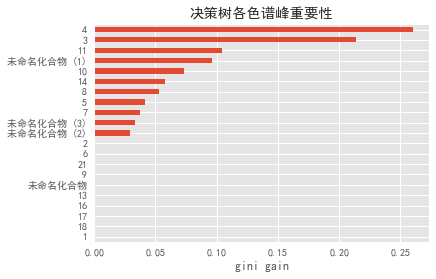

In [14]:
#决策树
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X,y)
s_imp_dt = pd.Series(dt.feature_importances_,index=X.columns)
s_imp_dt.sort_values().plot.barh()
plt.title('决策树各色谱峰重要性')
plt.xlabel('gini gain')

In [15]:
r2 = dt.score(X,y)
print('决策树拟合R2为 {}'.format(round(r2,2)))

决策树拟合R2为 1.0


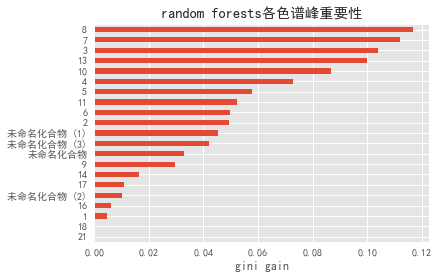

In [16]:
#random forests
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X,y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf],
             axis=0)
s_imp_rf = pd.Series(importances,index=X.columns)
s_imp_rf.sort_values().plot.barh()
plt.xlabel('gini gain')
plt.title('random forests各色谱峰重要性')

In [17]:
r2 = rf.score(X,y)
print('random forests拟合R2为 {}'.format(round(r2,2)))

random forests拟合R2为 1.0


ExtraTreesClassifier拟合R2为 1.0




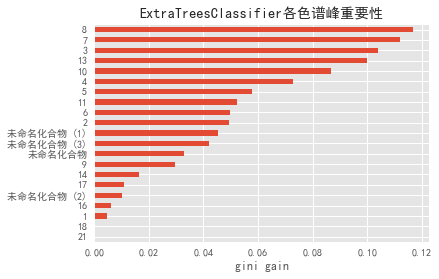

In [18]:
#ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=1)
et.fit(X,y)
imp = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et],
             axis=0)
s_et = pd.Series(imp,index=X.columns)
s_et.sort_values().plot.barh()
plt.xlabel('gini gain')
plt.title('ExtraTreesClassifier各色谱峰重要性')
print('ExtraTreesClassifier拟合R2为 {}'.format(round(et.score(X,y),2)))
print('\n')

In [19]:
#svm
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc = svc.fit(X,y)

LinearSVC拟合R2为 0.96


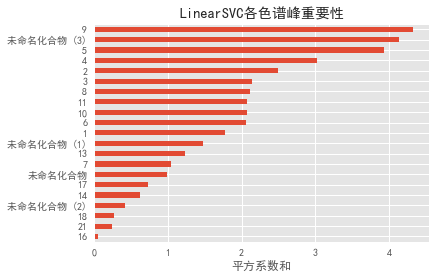

In [20]:
imp = (svc.coef_**2).sum(axis=0)#平方系数大小
s_svm = pd.Series(imp,index=X.columns)
s_svm.sort_values().plot.barh()
plt.xlabel('平方系数和')
plt.title('LinearSVC各色谱峰重要性')
print('LinearSVC拟合R2为 {}'.format(round(svc.score(X,y),2)))

In [21]:
ns = ['corr','chi2','plsda_coef','VIP','P1-loading','imp_dt','imp_rf','imp_et','imp_svm','F','mi']
imps = pd.DataFrame([s_corr,s_chi2,s_plsda_coef,s_VIP,s_P1,s_imp_dt,s_imp_rf,s_et,s_svm,s_F,s_mi],index=ns).T

In [22]:
from sklearn.preprocessing import minmax_scale
imps1 = imps.copy()
imps1 = imps1.apply(minmax_scale)

In [42]:
a = imps1.mean(axis=1).sort_values(ascending=False)
d = imps1.loc[imps1.mean(axis=1).sort_values(ascending=False).index,:]
data=d.unstack().reset_index()
data.columns=['metric','peak name','importance']

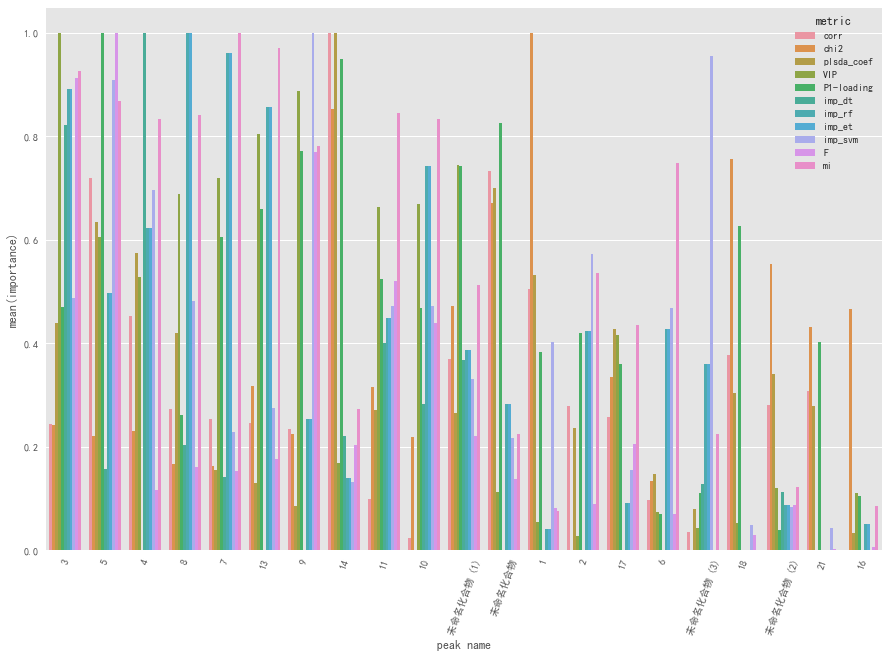

In [44]:
f = plt.figure(figsize=(15,10))
sns.barplot(x='peak name',y='importance',hue='metric',data=data)
ticks = plt.xticks(rotation=70)

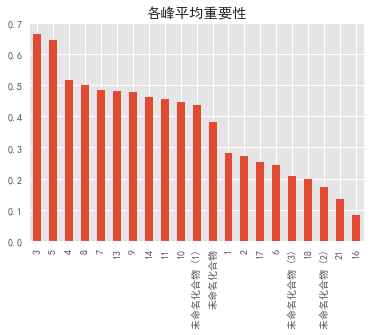

In [45]:
#平均重要性
a.sort_values(ascending=False).plot.bar()
plt.title('各峰平均重要性')